**Problem**: 

I want to approximate the non-linear data space that makes up a PyPSA simulation. Specifically, I want to approximate a modified IEEE 13 bus topology with a uniform (grid) input. Keeping model training time low is important.

**Objective**:

This notebook will only look at [deep neural networks](https://stats.stackexchange.com/questions/182734/what-is-the-difference-between-a-neural-network-and-a-deep-neural-network-and-w) (DNN). Per [1], the approximation should have a root mean sqaure error < 0.002 to ensure the approximation is not the largest source of error in the simulation. A standard linear regression will be used as a baseline. Since the approximation is time sensitive, a search for the ball park number of samples required for reasonable scores is performed. Once the number of samples to produce reasonable results is found, a grid search can be ran to determine optimal training parameters.

**Hypothesis**: 

Previously, linear regression models outperformed artificial neural networks when tested on simple, small radial networks [2]. Since the modified IEEE 13 bus network contains two transformers whos behaviour can become non-linear if their power limit is exceeded (which is allowed in power flow [3]), I suspect there are two possible scenarios:

1. Limit not exceeded: Linear regression outperforms DNN
2. Limit exceeded: DNN outperforms linear regressor because a DNN can capture non-linearity 

As for the number of samples required, historically 1e5-1e6 samples produces K-fold cross validation scores with low variance if the feature-label correlation is reasonable.

**Experimental Procedure**:

1. Determine the number of samples required to return reasonable scores with a three hidden layer, one hundred neurons per hidden layer, DNN K-fold cross validation. Reasonable scores is defined as:
  * R2 > 0.8
  * RMSE < 0.002
  * K-fold R2 variance one degree of magnitude less than R2
2. Using approximately that number of samples, run grid search to determine optimal parameters/hyperparameters

**Results**:

* 1e5 samples (mean R2: 0.84, std dev: 0.073)
* 1e4 samples (mean R2: 0.77, std dev: 0.081)

1e5 samples produced the best, most consistent results; roughly a 9% improvement over the next best, 1e4 samples, with a smaller standard deviation.



**Discussion**:

One approach to reduce the cost of simulation-based research is to copy the underlying model and evaluate the approximation [1][4].

It takes roughly 7 hours to create 1e5 samples (by running PyPSA sim) on Intel(R) Xeon(R) CPU E5-2650 v4 @ 2.20GHz


**Bibliography**

[1] https://github.com/mbardwell/masters

[2] Enhancing Power Flow Simulations Using Function Mapping. Michael Bardwell ; Petr Musilek. 2019 IEEE Canadian Conference on Electrical and Computer Engineering (CCECE)

[3] https://groups.google.com/forum/#!searchin/pypsa/mikey%7Csort:date/pypsa/FqfC_UR85k0/vBc7HYP_EQAJ

[4] ieee-13_timing-pfsim-vs-evaluating-models.ipynb


Table of Contents:
* Source data
* Analyse data
* Setup models
* Determine number of samples to get reasonable scores
* Search

In [1]:
import pypsa
import time
import logging
import numpy as np
import warnings

# warnings.filterwarnings('ignore')
logger = logging.getLogger("pypsa")
logger.setLevel("WARNING")
%matplotlib inline

import copy
import csv
import sys
import time

import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.metrics import r2_score

import pypsa
from n_dimensional_datasets import *
from plotter import *

from IPython.display import display # for better Pandas printing

In [2]:
def personalise_column_names(df, name):
        new_columns = []
        for column in df.columns:
            new_columns.append(name +  "-" + str(column))
        df.columns = new_columns
        return pd.DataFrame(df)

def collect_data(path_to_powerflow_data, data):
    '''
    Assumes folder tree has
    path_to_powerflow_data/
    -->datafiles
    -->results/
    '''
    data["loads"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "loads-p_set.csv"), "load")
    data["vmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vmags.csv"), "vmag")
    data["vangs"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vangs.csv"), "vang")
    data["qmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "qmags.csv"), "qmag")
    data["linemags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "linemags.csv"), "linemag")
    
import pandas as pd
import numpy as np
    
def set_uniform_sample_size(path_to_powerflow_data, data_to_change, n_samples, seed=None):
    '''
    Modifies common .csv files in PyPSA folders with uniformly sampled data 

    Parameters
    ----------
    path_to_powerflow_data: string
        ex: "/home/user/Documents/powerflow_data/"
    data_to_change: list of strings.
        ex: ["loads-p_set", "generators-p_max_pu", "snapshots"] 
    n_samples: int
    
    seed=None: int
    '''

    data = {}
    for datatype in data_to_change:
        data[datatype] = pd.read_csv(path_to_powerflow_data + datatype + ".csv")

    def increase_data(dataframe, n_samples, seed=None):
        addon = {}
        new_df_list = []
        for idx, column in enumerate(dataframe):
          
            if dataframe[column].dtype == np.float64 or dataframe[column].dtype == np.int64:
                ## special cases
                if datatype == "generators-p_max_pu":
                    # add a ridiculous amount of generation so the is always enough power and sim doesn't fail
                    addon[column] = np.random.RandomState(seed=seed).uniform(low=100, high=200, size=n_samples)
                elif datatype == "snapshots":
                    addon[column] = np.ones(n_samples)
                else:
                    addon[column] = np.random.RandomState(seed=seed).uniform(low=0, high=0.5, size=n_samples)
            elif dataframe[column].dtype == object:
                # assuming object is datetime column
                latest_datetime = pd.to_datetime(dataframe[column][0])
                addon[column] = []
                for sample in range(n_samples):
                    addon[column].append(latest_datetime + pd.Timedelta(hours=(1+sample)))
            else:
                raise TypeError("dataframe[column] type: {} should be object or float64/int64".format(
                    type(dataframe[column].dtype)))
        addon_dataframe = pd.DataFrame(addon)
        return dataframe.head(1).append(addon_dataframe)

    for datatype in data:
        data[datatype] = increase_data(data[datatype], n_samples-1, seed) # -1 is for original sample, which stays
        data[datatype].to_csv(path_to_powerflow_data + datatype + ".csv", index=False)
        print("Datatype {} stored".format(datatype))

def create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None):
    import os
    import shutil
    from pathlib import Path
    import pypsa

    if not os.path.isdir(path_to_powerflow_data):
        src = Path(path_to_powerflow_data).parents[0] / "ieee-13-with-load-gen/" # original modified IEEE model
        shutil.copytree(src, path_to_powerflow_data)

    set_uniform_sample_size(path_to_powerflow_data, data_to_change, sample_size, seed=None)

    network = pypsa.Network(import_name=path_to_powerflow_data)
    network.pf()

    save_path = path_to_powerflow_data + "results/"
    network.buses_t.v_mag_pu.to_csv(save_path + "vmags.csv")
    network.buses_t.v_ang.to_csv(save_path + "vangs.csv")
    network.buses_t.q.to_csv(save_path + "qmags.csv")
    network.lines_t.p0.to_csv(save_path + "linemags.csv")
    
def backup_samples(src, dest):
    '''
    thanks https://www.pythoncentral.io/how-to-recursively-copy-a-directory-folder-in-python/
    '''
    import os
    import errno
    import shutil
    
    try:
        if os.path.isdir(dest):
            shutil.rmtree(dest)
        shutil.copytree(src, dest)
        print("Backup to {} successful".format(dest))
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Directory not copied. Error: %s' % e)

# Source Data

In [3]:
## USER INPUT
sample_size = 100000 # this is the max number of samples available

data_to_change = ["loads-p_set", "snapshots", "loads-q_set"]

path_to_powerflow_example = "../../pypsa/examples/ieee-13/"
path_to_powerflow_data = (path_to_powerflow_example +
                          "/ieee-13-with-load-gen-uniform-data-"
                          + str(sample_size) +
                          "-samples/")
path_to_powerflow_results = path_to_powerflow_data + "results/"

In [4]:
## Uncomment to generate load samples for modified IEEE-13 network
# if sample_size > 10000:
#     user = input("Are you sure [y/n]? This could erase hours worth of data")
#     if user == "y":
#         backup_samples(path_to_powerflow_results, path_to_powerflow_data + "results-backup/")
#         create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)
# else:
#     create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)

data = {"loads": [], "vmags": [], "vangs": [], "qmags": [], "linemags": []}
collect_data(path_to_powerflow_data, data)

# Analyse Data

In [5]:
features = data["loads"].drop("load-name", axis=1)
labels = data["vmags"].drop(["vmag-name", "vmag-Substation"], axis=1) #loc[:,["vmag-632", "vmag-671", "vmag-675"]]
features_and_labels = features.join(labels)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f284f497890>,
      dtype=object)

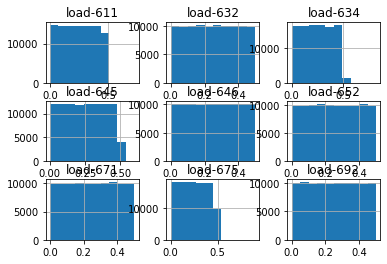

In [6]:
features.hist()

In [7]:
labels.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2883e16710>,
      dtype=object)

In [8]:
corr_matrix = labels.join(features).corr()

# only loads for columns
cols = [c for i, c in enumerate(corr_matrix.columns) if corr_matrix.keys().str.contains("^load", regex=True)[i]]
reduced_corr_matrix = corr_matrix[cols]
reduced_corr_matrix["row average"] = pd.Series(reduced_corr_matrix.mean(axis=1))
# only voltages for rows
rows = reduced_corr_matrix.index[reduced_corr_matrix.index.str.contains("load")]
reduced_corr_matrix.drop(rows, inplace=True)
reduced_corr_matrix = reduced_corr_matrix.append(pd.Series(reduced_corr_matrix.mean(), name="column average"))

display(reduced_corr_matrix)

/home/ubuntu/anaconda3/envs/sim-approx/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/sim-approx/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


load-632  load-634  load-645  load-646  load-652  load-671  \
vmag-650       -0.008439  0.001458 -0.002953 -0.000081 -0.001955 -0.007134   
vmag-646       -0.196512 -0.200144 -0.487273 -0.671172 -0.211606 -0.204674   
vmag-645       -0.219407 -0.223990 -0.546822 -0.558979 -0.235927 -0.229190   
vmag-632       -0.316812 -0.320804 -0.319882 -0.333944 -0.339195 -0.329811   
vmag-633       -0.286406 -0.512513 -0.289868 -0.302645 -0.307178 -0.298881   
vmag-634       -0.286326 -0.512387 -0.289801 -0.302548 -0.307111 -0.298800   
vmag-611       -0.157880 -0.158084 -0.155850 -0.168281 -0.463138 -0.316864   
vmag-684       -0.170285 -0.171447 -0.168631 -0.182151 -0.502244 -0.343257   
vmag-671       -0.196724 -0.199334 -0.196651 -0.210183 -0.410146 -0.399117   
vmag-692       -0.196689 -0.199299 -0.196616 -0.210148 -0.410075 -0.399049   
vmag-675       -0.187323 -0.189802 -0.187164 -0.200840 -0.391617 -0.380550   
vmag-652       -0.140446 -0.141170 -0.137119 -0.151906 -0.698675 -0.281787   
vmag-680       -0.196724 -0.199334 -0.196651 -0.210183 -0.410146 -0.399117   
column average -0.196921 -0.232835 -0.244252 -0.269466 -0.360693 -0.299095   

                load-675  load-692  load-611  row average  
vmag-650       -0.001353 -0.004306 -0.001971    -0.002970  
vmag-646       -0.199273 -0.208235 -0.211118    -0.287779  
vmag-645       -0.223332 -0.233060 -0.236599    -0.300812  
vmag-632       -0.324215 -0.334387 -0.339914    -0.328774  
vmag-633       -0.292050 -0.303695 -0.307554    -0.322310  
vmag-634       -0.291940 -0.303616 -0.307463    -0.322221  
vmag-611       -0.313902 -0.320260 -0.600170    -0.294936  
vmag-684       -0.340429 -0.346904 -0.501052    -0.302933  
vmag-671       -0.395772 -0.403272 -0.410221    -0.313491  
vmag-692       -0.395916 -0.403413 -0.410151    -0.313484  
vmag-675       -0.479096 -0.385147 -0.391644    -0.310354  
vmag-652       -0.280290 -0.284874 -0.411965    -0.280915  
vmag-680       -0.395772 -0.403272 -0.410221    -0.313491  
column average -0.302565 -0.302649 -0.349234    -0.284190

# Setup Models

In [9]:
import csv
import datetime

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import train_test_split

from scoring import rmse

In [10]:
def set_data_size(n_samples, n_training_samples):
    X_train, X_val, y_train, y_val, test_idx, train_idx = train_test_split(features,
                                                                           labels,
                                                                           range(features.shape[0]),
                                                                           train_size=n_training_samples,
                                                                           test_size=n_samples-n_training_samples,
                                                                           random_state=None)
    X_train = X_train.values
    y_train = y_train.values
    X_val = X_val.values
    y_val = y_val.values

    return X_train, y_train, X_val, y_val

# Determine number of samples to get reasonable scores

In [11]:
# setup model parameters/hyperparameters

'''
dnn hyperparameters are chosen from sandbox testing. On average the model attempts to converge 
(with other parameters it sometimes gives up early).
'''
hidden_layer_size = 100
dnn = MLPRegressor(hidden_layer_sizes=(hidden_layer_size, hidden_layer_size, hidden_layer_size),
                   activation="logistic",
                   solver="adam",
                   alpha=0.000001,
                   learning_rate_init=1e-5,
                   max_iter=100000,
                   n_iter_no_change=100,
                   tol=1e-9,
                  )

linear = LinearRegression()

In [12]:
# dnn_xval_scores = []
# linear_xval_scores = []
# for i, n_samples in enumerate([100, 1000, 10000, 100000]):
#     current_iteration = i

#     n_training_samples = int(n_samples*(80/100))
#     X_train, y_train, X_val, y_val = set_data_size(n_samples, n_training_samples)

#     print("\n\nRun: ", current_iteration)
#     print("n_training_samples: ", n_training_samples)
#     print("n_validation_samples: ", n_samples-n_training_samples)
#     print("n_features: ", X_train.shape[1])
#     print("n_labels: ", y_train.shape[1])

#     ## dnn
#     print("\n\nANN\n\n")
#     time_start = time.time()
#     dnn_xval_scores.append(cross_validate(dnn, 
#                                           X_train, 
#                                           y_train, 
#                                           cv=5, 
#                                           n_jobs=-1, 
#                                           scoring=make_scorer(r2_score)))
#     time_dnn = time.time()
#     print("cross validation training time {:.5}".format(time_dnn-time_start))
#     print("cross validation training scores: ")
#     dnn_results = pd.DataFrame(dnn_xval_scores[current_iteration])
#     dnn_results.columns = ["dnn_"+col for col in dnn_results.columns]   
#     display(dnn_results)

#     dnn.fit(X_train, y_train)
#     print("non-cross validation model scores for reference:")
#     print("training score: ", r2_score(y_train, dnn.predict(X_train)))
#     print("validation score: ", r2_score(y_val, dnn.predict(X_val)))
#     print("rmse: ", rmse(dnn.predict(X_val), y_val))



#     ## linear regression
#     print("\n\nLINEAR REGRESSION\n\n")
#     time_start = time.time()
#     linear_xval_scores.append(cross_validate(linear,
#                                              X_train,
#                                              y_train,
#                                              cv=5,
#                                              n_jobs=-1,
#                                              scoring=make_scorer(r2_score)))

#     time_linear = time.time()
#     print("cross validation training time {:.5}".format(time_linear-time_start))
#     print("cross validation training scores: ")
#     linear_results = pd.DataFrame(linear_xval_scores[current_iteration])
#     linear_results.columns = ["linear_"+col for col in linear_results.columns]
#     display(linear_results)

#     linear.fit(X_train, y_train)
#     print("non-cross validation model scores for reference:")
#     print("training score: ", r2_score(y_train, linear.predict(X_train)))
#     print("validation score: ", r2_score(y_val, linear.predict(X_val)))
#     print("rmse: ", rmse(linear.predict(X_val), y_val))

#     ## model statistics
#     datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
#     results_to_save = dnn_results.join(linear_results).round(3)
#     results_to_save.to_csv(path_to_powerflow_data + 
#                            "/results/approximating_with_dnn_results-{}_samples-{}.csv".format(n_samples, 
#                                                                                              datetimestamp))

# Search

In [ ]:
import itertools
from sklearn.model_selection import RandomizedSearchCV

In [27]:
n_samples = 100000
if n_samples < 100000:
    raise ValueError("So you don't accidentally run this on 100 samples again")
n_training_samples = int(n_samples*(80/100))
X_train, y_train, X_val, y_val = set_data_size(n_samples, n_training_samples)

In [ ]:
dnn = MLPRegressor()

# lists in a list because [a] + [b] + [c] wraps poorly
hidden_layer_sizes = [[tup for tup in itertools.product(range(5,100,5), repeat=1)] +
                      [tup for tup in itertools.product(range(5,100,5), repeat=2)] +
                      [tup for tup in itertools.product(range(5,100,5), repeat=3)] +
                      [tup for tup in itertools.product(range(5,100,5), repeat=4)]]

params = {"hidden_layer_sizes": hidden_layer_sizes[0], 
          "activation": ["relu", "logistic", "tanh"],
          "alpha": [i*0.9/10000 for i in range(10000)], # min:0, middle:0.45, max:0.9
          "beta_1": [i*0.99/1000 for i in range(1,1000)], # min:0.00099, middle:0.495, max: 0.99
          "beta_2": [i*0.999/1000 for i in range(1,1000)], # min:0.000999, middle:0.4995, max: 0.999
          "solver" : ["lbfgs", "sgd", "adam"],
          "learning_rate_init": [1e-5],
          "max_iter": [100000],
          "n_iter_no_change": [100],
          "tol": [1e-9],}

grid = RandomizedSearchCV(dnn, params, cv=2, n_iter=100, n_jobs=-1, refit=False, 
                          scoring={"r2": make_scorer(r2_score), "rmse": make_scorer(rmse)}, iid=False, verbose=10)

grid.fit(X_train, y_train)

print("\n\nANN\n\n")
ann_grid_results = pd.DataFrame(grid.cv_results_)
display(ann_grid_results)
datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
ann_grid_results.to_csv(path_to_powerflow_data + 
                        "/results/approximating_with_dnn_grid_results-{}_samples-{}.csv".format(n_samples, 
                                                                                                datetimestamp))

Fitting 2 folds for each of 540 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.5min


In [25]:
## for reading values if you closed the notebook
# foo = pd.read_csv(path_to_powerflow_data + 
#             "results/" + "approximating_with_dnn_grid_results-100_samples-2019-09-12-09-05.csv")
# pd.set_option('display.max_rows', 600)
# display(foo)

Unnamed: 0  mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0             0       0.138656      0.017196         0.000636    2.598763e-05   
1             1      51.254320     12.205606         0.000624    4.434586e-05   
2             2      35.382297      2.748715         0.000562    4.506111e-05   
3             3       0.121458      0.009998         0.000661    8.952618e-05   
4             4      76.081360      0.292858         0.000619    5.519390e-05   
5             5      52.083454      4.230076         0.000548    3.147125e-05   
6             6       0.225490      0.061310         0.000723    5.578995e-05   
7             7      84.871233      1.166922         0.000672    1.883507e-05   
8             8      37.207927      0.591776         0.000641    5.590916e-05   
9             9       0.496258      0.018849         0.000621    3.373623e-05   
10           10     125.168332      2.261857         0.000962    1.043081e-04   
11           11      14.290884      0.207243         0.000793    2.050400e-05   
12           12       0.773836      0.022563         0.000790    1.931190e-05   
13           13     177.131659      0.815038         0.008884    8.051753e-03   
14           14      19.073212      0.458578         0.000829    1.990795e-05   
15           15       0.102191      0.005563         0.000483    1.418591e-05   
16           16      65.650339      0.242953         0.000690    1.251698e-05   
17           17      38.030347      0.236540         0.000610    5.006790e-06   
18           18       0.211504      0.009786         0.000972    6.949902e-05   
19           19      75.067131      0.039375         0.000644    5.805492e-05   
20           20      42.991390      3.402625         0.000658    2.551079e-05   
21           21       0.135133      0.014564         0.000561    6.794930e-06   
22           22      64.208700     21.622117         0.000864    9.298325e-05   
23           23      41.298805      7.424260         0.000580    4.208088e-05   
24           24       0.367232      0.038096         0.000615    7.390976e-06   
25           25     123.019898      0.334043         0.000735    7.748604e-06   
26           26      26.137280      1.495077         0.000750    6.246567e-05   
27           27       0.766650      0.039295         0.000740    3.504753e-05   
28           28     177.621180      1.628106         0.000948    1.528263e-04   
29           29      33.104715      1.603184         0.000846    7.748604e-06   
30           30       0.076557      0.001661         0.000460    1.251698e-05   
31           31      66.151907      0.556871         0.000814    1.233816e-04   
32           32      50.770714      2.823021         0.000638    8.368492e-05   
33           33       0.105234      0.000087         0.000468    5.006790e-06   
34           34      75.540105      1.640236         0.000693    8.606911e-05   
35           35      60.117721      1.220889         0.000884    1.063347e-04   
36           36       0.147770      0.032885         0.000558    4.994869e-05   
37           37      85.664277      1.379579         0.000646    3.302097e-05   
38           38      68.264539      4.259726         0.000669    7.879734e-05   
39           39       0.431593      0.002581         0.000703    7.688999e-05   
40           40     123.882380      0.642947         0.000760    4.732609e-05   
41           41      16.344438      0.830208         0.006936    6.224871e-03   
42           42       0.766505      0.002365         0.000837    2.479553e-05   
43           43     179.025226      0.173258         0.000790    1.955032e-05   
44           44      21.756871      0.684242         0.000780    6.115437e-05   
45           45       0.075881      0.005771         0.000472    7.152557e-06   
46           46      64.296046      0.569338         0.000643    5.102158e-05   
47           47      39.948760      0.991260         0.000611    2.813339e-05   
48           48       0.100947      